# Preparing the environment

In [42]:
from algorithms import UCB, ImprovedUCB
from casino import Casino
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from IPython.core.pylabtools import figsize

In [2]:
%load_ext autoreload
%autoreload 2

> **Note** :
> The experiments done in this notebook may not be **samely reproducible** as we do not specify a fixed seed for 
> `numpy.random`.

# Analyzing the UCB algorithm

- First let's create an instance of a `Casino`. It will have 10 machines each with a randomly generated payoff. These payoffs will be the same for all the following experiments, meaning only one instance of `Casino` will be used.
- Once this is done, we can create an instance of `UCB` that will use the created casino for the calculations and an initial cerdit of 1000.

In [52]:
nb_machines = 10
initial_credit = 1000

casino = Casino(nb=nb_machines)
ucb = UCB(casino, initialCredit=initial_credit, confidence=1)

Let's get the best confidence value for the UCB. We can do that by trying different values of confidence between 0.1 and 1.0 each one multiple times, calculate the mean and draw the corresponding curve. We will repeat UCB on each confidence value 50 times before calculating the mean so that the value does not get biaised as the casino machines use probabilities to return rewards.

Looking for the best confidence:   0%|          | 0/900 [00:00<?, ?it/s]

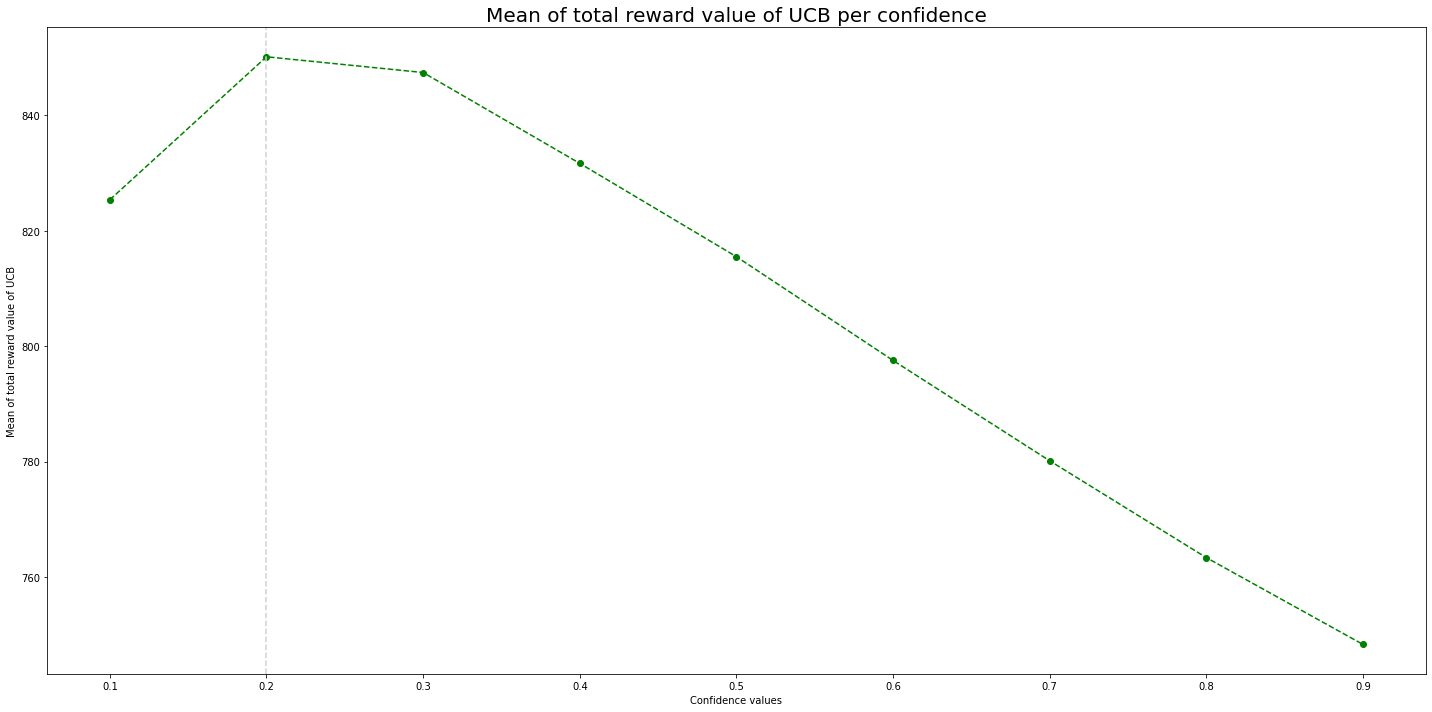

In [53]:
confidence_values = np.arange(0.1, 1.0, 0.1)
total_rewards = []
repetition = 100
with tqdm(
    total=len(confidence_values) * repetition, desc="Looking for the best confidence"
) as pbar:
    for c in range(len(confidence_values)):
        ucb.confidence = confidence_values[c]
        reward = 0.0
        for i in range(repetition):
            reward += ucb.do_ucb()  # automatically initializes environment at each call
            pbar.update(1)
        total_rewards.append(reward / repetition)


fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel("Mean of total reward value of UCB")
ax.set_xlabel("Confidence values")
ax.set_title("Mean of total reward value of UCB per confidence", fontsize=20)
plt.plot(confidence_values, total_rewards, marker="o", linestyle="--", color="g")
ax.axvline(
    x=confidence_values[np.argmax(total_rewards)], linestyle="--", color="lightgrey"
)
fig.tight_layout()

The curve shows the value of confidence that gave the maximum mean total reward is 0.2. We will be using this value from now on.

In [54]:
ucb.confidece = 0.2

In [55]:
# UCB rewards and UCB cumulative rewards
ucb_rewards = []
time_steps = range(initial_credits)
ucb.initialize()
reward, _ = ucb.do_one_step_ucb()
while reward is not None:
    ucb_rewards.append(reward)
    reward, _ = ucb.do_one_step_ucb()
cumulative_ucb_rewards = np.cumsum(ucb_rewards)

# Optimal rewards and cumulative optimal rewards
optimal_rewards = [casino.real_best_choice().play() for _ in range(initial_credits)]
cumulative_optimal_rewards = np.cumsum(optimal_rewards)

In [56]:
# Mean UCB rewards per time
ucb_rewards = np.zeros(initial_credit)
episodes = 1000  # A thousand for final results

for episode in tqdm(range(episodes), desc=f"Running {episodes} episodes"):
    ucb.initialize()
    reward, time_step = ucb.do_one_step_ucb()
    episode_rewards = np.zeros(initial_credit)
    while reward is not None:
        episode_rewards[time_step] = reward
        reward, time_step = ucb.do_one_step_ucb()

    ucb_rewards = ucb_rewards + (episode_rewards - ucb_rewards) / (episode + 1)

Running 1000 episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

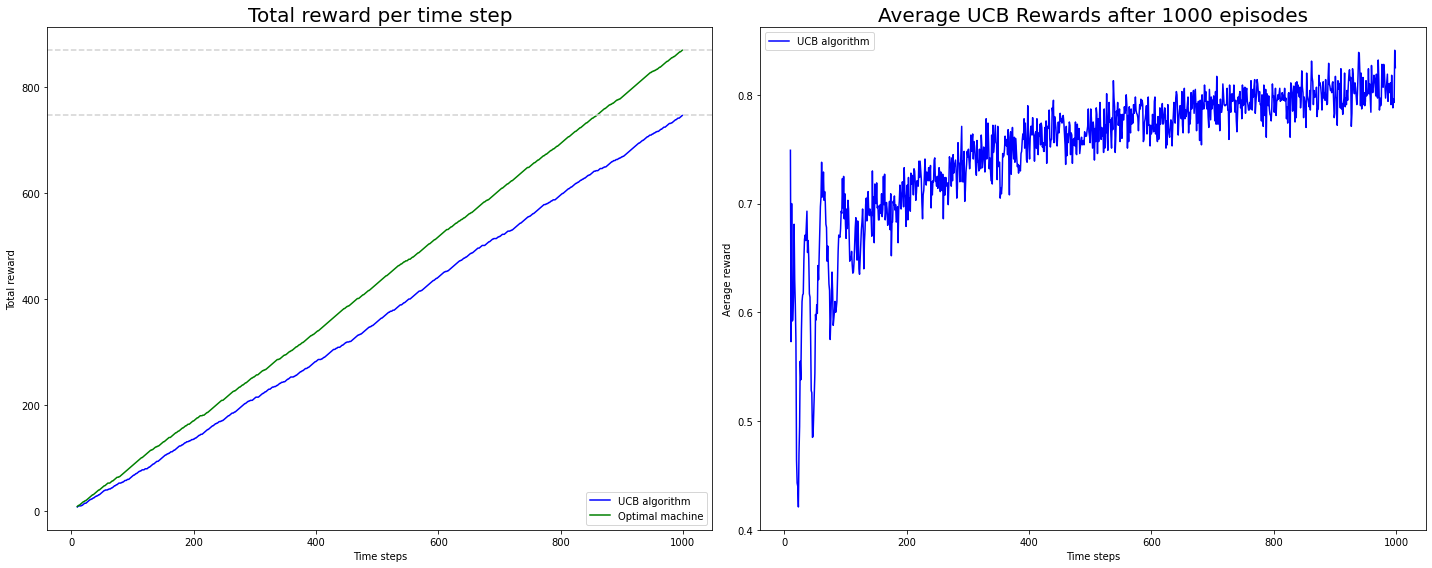

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# We remove the first nb=10 time steps from the plot as they were only used for initializing UCB rewards
ax1.plot(time_steps[10:], cumulative_ucb_rewards[10:], color="b", label="UCB algorithm")
ax1.plot(time_steps[10:], cumulative_optimal_rewards[10:], color="g", label="Optimal machine")
ax1.axhline(y=np.max(cumulative_ucb_rewards), linestyle="--", color="lightgrey")
ax1.axhline(y=np.max(cumulative_optimal_rewards), linestyle="--", color="lightgrey")
ax1.set_ylabel("Total reward")
ax1.set_xlabel("Time steps")
ax1.set_title("Total reward per time step", fontsize=20)
ax1.legend()

ax2.plot(time_steps[10:], ucb_rewards[10:], color="b", label="UCB algorithm")
ax2.set_ylabel("Aerage reward")
ax2.set_xlabel("Time steps")
ax2.set_title(f"Average UCB Rewards after {episodes} episodes", fontsize=20)
ax2.legend()

fig.tight_layout()

# Improved version of the UCB algorithm

An imrproved version of the UCB mehtod has been implemented in the `ImprovedUCB` class. It is inspired by the work in [this paper](http://personal.unileoben.ac.at/rortner/Pubs/UCBRev.pdf). Let's compare its performance with the original one.